# Setup

In [1]:
%cd ..

/home/pdona/VariousExercises/SentimentAnalysisAmazonMerchant


In [2]:
from AmazonReviewScraper.models import Review, Product, Merchant
import AmazonReviewScraper.amazon_review_database as db
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Load data from database

In [3]:
df = pd.read_sql(
    db.session.query(
        Merchant, Product, Review).filter(Review.product_id == Product.id, Product.merchant_id == Merchant.id,).statement,
    con=db.engine
)
df.drop(['id', 'id_1', 'id_2', 'merchant_id', 'product_id'],
              axis='columns', inplace=True)
df.columns


Index(['me', 'name', 'asin', 'title', 'average_review', 'user', 'rating',
       'title_1', 'date', 'verified', 'content', 'helpfulvote'],
      dtype='object')

### Format the feature names of the dataframe

In [4]:
df.columns = ['merchant_token', 'merchant_name', 'product_asin', 'product_name', 'product_average_review', 'review_user', 'review_rating',
                    'review_title', 'review_date', 'review_verified', 'review_content', 'review_helpful_vote']


# Basic EDA

### First inspection of the data

We look the the datatypes and the number of entries

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103007 entries, 0 to 103006
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   merchant_token          103007 non-null  object 
 1   merchant_name           103007 non-null  object 
 2   product_asin            103007 non-null  object 
 3   product_name            103007 non-null  object 
 4   product_average_review  103007 non-null  float64
 5   review_user             103007 non-null  object 
 6   review_rating           103007 non-null  int64  
 7   review_title            103007 non-null  object 
 8   review_date             103007 non-null  object 
 9   review_verified         103007 non-null  bool   
 10  review_content          103007 non-null  object 
 11  review_helpful_vote     10407 non-null   float64
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 8.7+ MB


Look for missing data

In [6]:
df.isnull().sum()


merchant_token                0
merchant_name                 0
product_asin                  0
product_name                  0
product_average_review        0
review_user                   0
review_rating                 0
review_title                  0
review_date                   0
review_verified               0
review_content                0
review_helpful_vote       92600
dtype: int64

Data is fairly complete (we scraped it), the only feature with missing data is the `review_helpful_vote`. It is the number of "helpful vote" the review received. If null it means that it was voted as helpful 0 times.

In [7]:
df['review_helpful_vote'].fillna(0,inplace=True)

### Ratings distribution

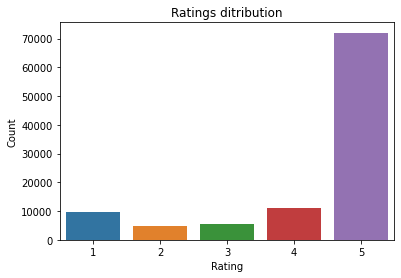

In [8]:
ax=sns.countplot(data=df,x='review_rating')
ax.set(title="Ratings ditribution",xlabel="Rating",ylabel="Count");

There is a huge unbalance between High rating and the rest

### Helpful vote

We already know that there are 90K-ish entries without a helpful vote. We make a categorical feature that tells us if there is a vote or not.

In [9]:
df['review_helpful'] = df['review_helpful_vote'].apply(lambda x : 1 if x > 0 else 0)

In [10]:
df['review_helpful'].value_counts()


0    92600
1    10407
Name: review_helpful, dtype: int64

[Text(0.5, 1.0, 'Helpful review ditribution (divided by rating)'),
 Text(0.5, 0, 'Helpful'),
 Text(0, 0.5, 'Count'),
 [Text(0, 0, 'No'), Text(1, 0, 'Yes')]]

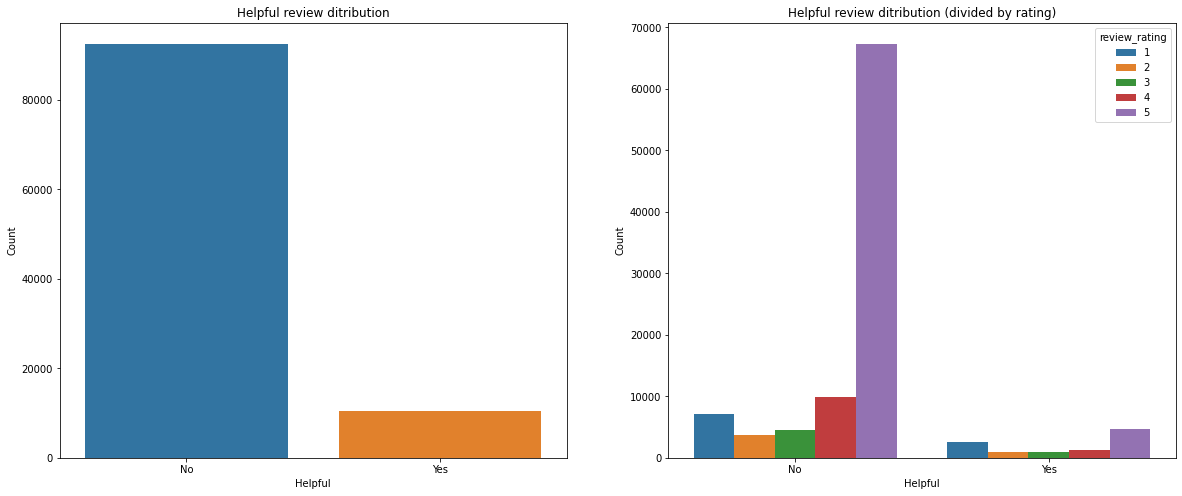

In [11]:
fig, ax = plt.subplots(nrows=1,
                       ncols=2, figsize=(20, 8))
sns.countplot(data=df, x="review_helpful",ax=ax[0])
sns.countplot(data=df, x='review_helpful',
              hue='review_rating', ax=ax[1])
ax[0].set(title="Helpful review ditribution", xlabel="Helpful",
          ylabel="Count", xticklabels=("No", "Yes"))
ax[1].set(title="Helpful review ditribution (divided by rating)", xlabel="Helpful",
          ylabel="Count", xticklabels=("No", "Yes"))


Among the helpful reviews the difference among ratings is way smaller than non helpful reviews.

### Review content

We perform the text analysis later. We supplement the content with the length of the review 

In [12]:
df['review_length'] = df['review_content'].apply(len)


<AxesSubplot:xlabel='review_length', ylabel='Count'>

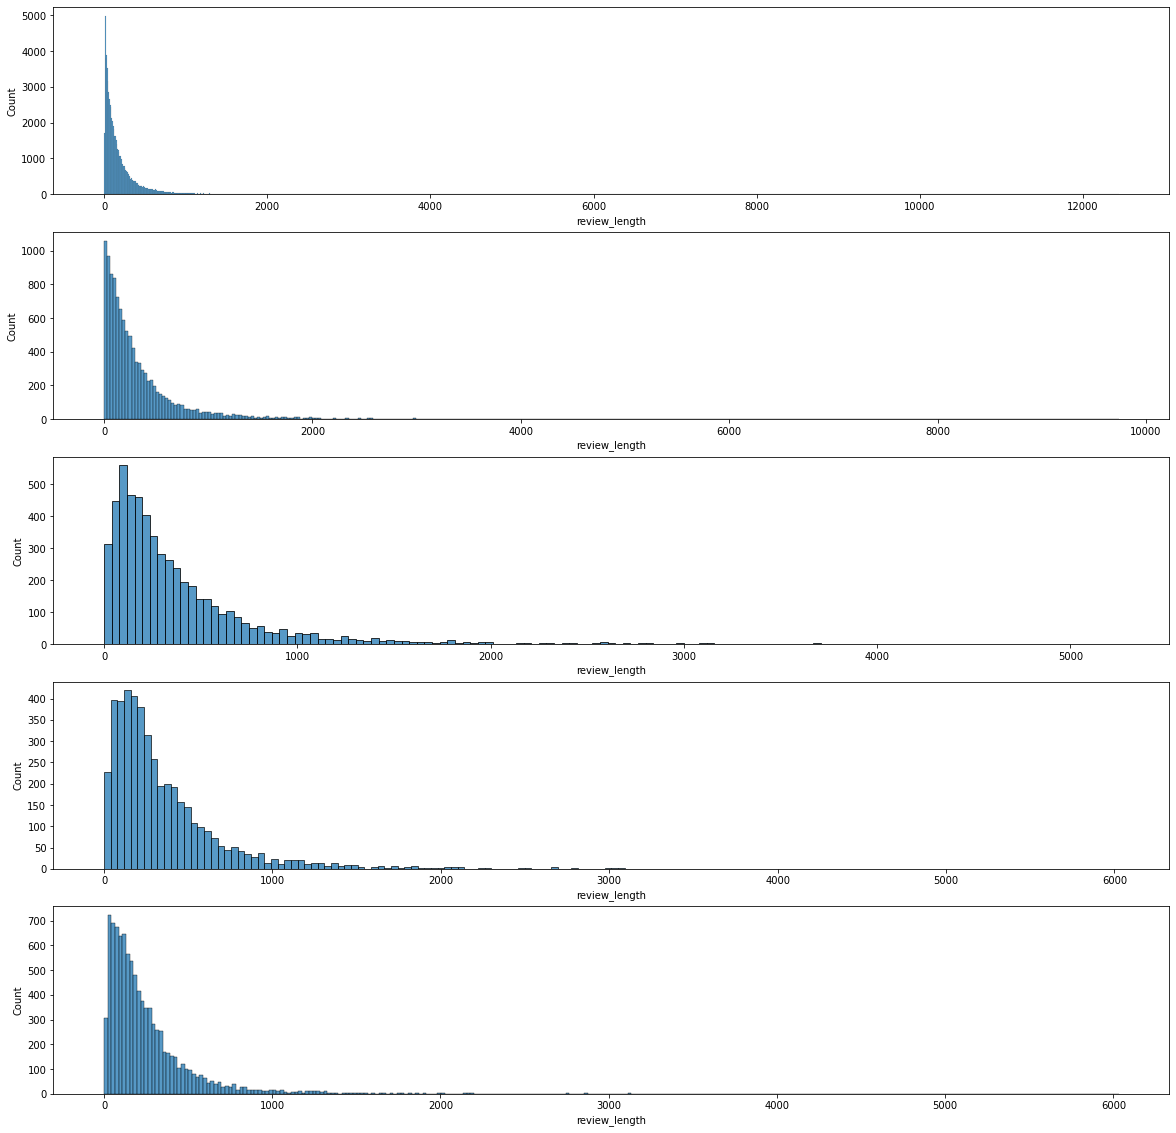

In [13]:
fig, ax = plt.subplots(nrows=5,
                       ncols=1, figsize=(20, 20))
sns.histplot(data=df.query("review_rating == 5"), x="review_length", ax=ax[0])
sns.histplot(data=df.query("review_rating == 4"), x="review_length", ax=ax[1])
sns.histplot(data=df.query("review_rating == 3"), x="review_length", ax=ax[2])
sns.histplot(data=df.query("review_rating == 2"), x="review_length", ax=ax[3])
sns.histplot(data=df.query("review_rating == 1"), x="review_length", ax=ax[4])


In [14]:
df.groupby("review_rating").agg({"review_length": ['mean','median','min','max']})




review_length                  
                       mean median min    max
review_rating                                
1                255.521590  175.0   0   6031
2                370.195048  248.0   0   6025
3                380.714647  252.0   0   5249
4                342.807132  200.0   0   9737
5                192.652654  109.0   0  12437

In [15]:
len(df.query("review_length == 0"))

35

Looks like average ratings tends to be better argumented. 1 and 5 reviews are the easy to go for less argumented reviews. The 0 lengths are a very small percentage. The longest review is rated 5.

<AxesSubplot:xlabel='review_rating', ylabel='review_length'>

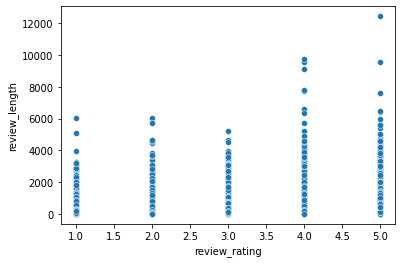

In [16]:
sns.scatterplot(data=df, x="review_rating",y="review_length")


## Polarity

Polarity is a metric that "measures" the positivity of the statement. Float between -1 and 1.

In [17]:
from textblob import TextBlob
def pol(x): return TextBlob(x).sentiment.polarity
# depending on the size of your data, this step may take some time.
df['review_polarity'] = df['review_content'].apply(pol)


<AxesSubplot:xlabel='review_polarity', ylabel='Count'>

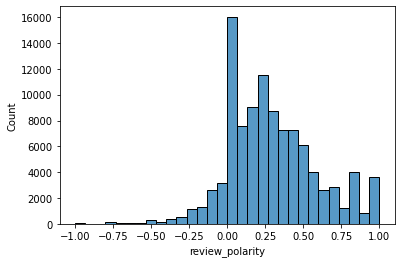

In [18]:
sns.histplot(data=df, x="review_polarity",bins=30)


There is an excess of 0 polarity reviews, the average is positive.

<AxesSubplot:xlabel='review_rating', ylabel='review_polarity'>

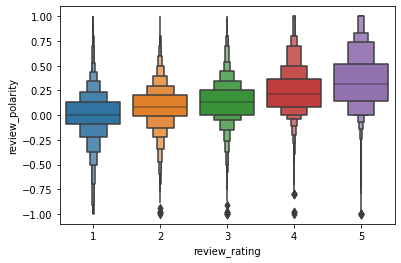

In [19]:
sns.boxenplot(data=df, x="review_rating", y="review_polarity")


It looks like there is a correlation between polarity of the review and the rating. However, there are many outliers. Some 5 rated reviews have very negative polarity and some 1 rated reviews have very positive polarity. 

Let's examine these outliers

In [20]:
df.query("review_rating == 1 and review_polarity == 1").sample(
    10)['review_content'].tolist()

['Put it in the perfect spot or it won’t charge!',
 'It never worked, it is either defective or place tour cell phone on it has to be precisely perfect.',
 'Charges great over night but your cover needs to off each time and every time . You make the call . But for the price !?!? You can’t beat it. It stops changing after 2 months',
 "Worked good for a month then it wouldn't keep a charge so I had to keep it plugged in to a charger then it started to cut out so I just trashed the piece of junk!!!",
 'It’s not the best, doesn’t charge my phone well',
 'I bought this cable 2 weeks ago and now it stopped working, even when it looks perfect so I don’t recommend this product',
 "It doesn't work all the time. I have a 4-port USB hub from Anker which worked perfectly. The 7-in 1 didn't.",
 'Funciono bien por un mes .. ahora no carga nada ... no lo compres!!!Work good for 1 month.. after that no work!Don’t buy it!!!',
 'Product was great until 4 months after. USB ports don’t work anymore!!!',
 

The majority of the positivity here it beacuse of comparison to another product (or the same product but `before`) that was positively rated.

In [21]:
df.query("review_rating == 5 and review_polarity == -1").head()['review_content'].tolist()

['The sturdy cables and chargers replace the awful chargers and cables that come with your mobile or computer.',
 'It stopped working after a week of use. Terrible terrible terrible.',
 'Have ordered before and not been disappointed! Quality work, lasts a looooong time no matter what the abuse!',
 "Alot of features...just buy and test it out....you wouldn't be DISAPPOINTED at all!!!",
 'Neighbors shoot guns. Very annoying to me. Got these. Shoot all you want']

These are very phew. There is one case of possible mislabel. One positive review with negatice gergon and 3 comparisons.

## Subjectivity

Subjectivity is used for individual sentences to determine whether a sentence expresses an opinion or no. It is a float between 0 and 1. When it is close to 0, it is more about facts. When subjectivity increases, it comes close to be an opinion.

In [22]:
def sub(x): return TextBlob(x).sentiment.subjectivity
# depending on the size of your data, this step may take some time.
df['review_subjectivity'] = df['review_content'].apply(sub)


<AxesSubplot:xlabel='review_subjectivity', ylabel='Count'>

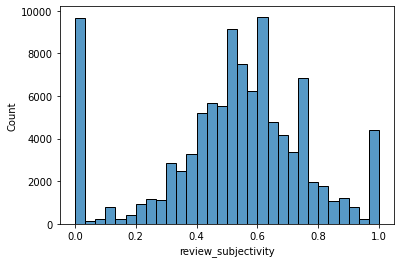

In [23]:
sns.histplot(data=df, x="review_subjectivity", bins=30)


<AxesSubplot:xlabel='review_rating', ylabel='review_subjectivity'>

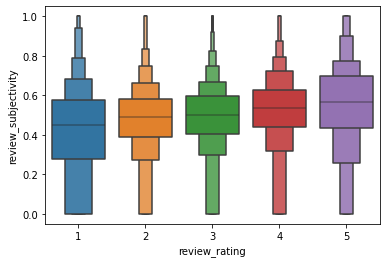

In [24]:
sns.boxenplot(data=df, x="review_rating", y="review_subjectivity")

It seems that subjectivity is not that informative sicne the variance looks very large. 

In [25]:
tmp_df = df.copy()
tmp_df['review_date'] = pd.to_datetime(tmp_df['review_date'])
test_df = tmp_df.groupby(pd.Grouper(key='review_date', freq='M')).count()

<AxesSubplot:xlabel='review_date', ylabel='review_rating'>

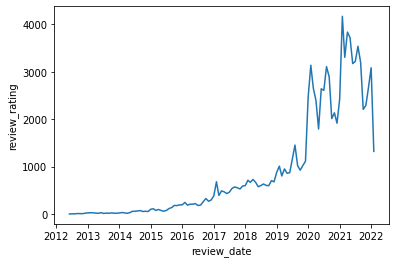

In [26]:
sns.lineplot(data=test_df,x="review_date",y="review_rating")

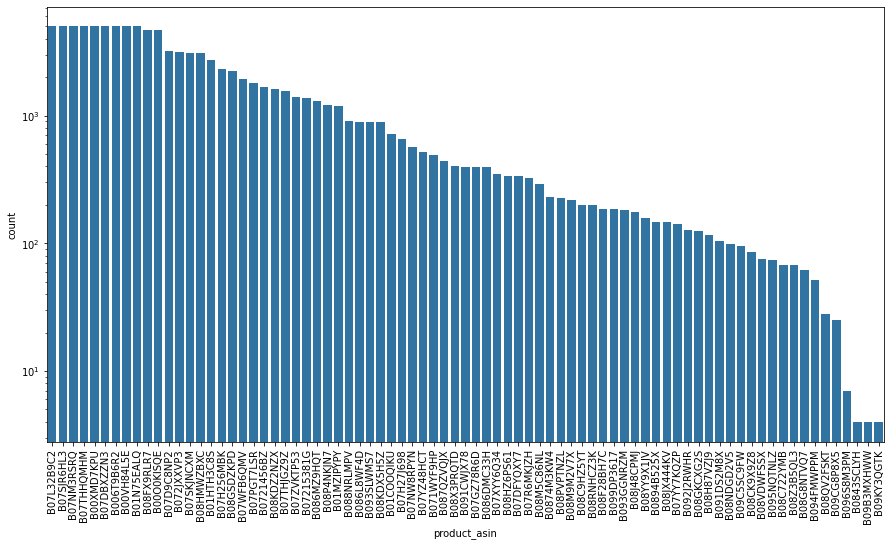

In [27]:
plt.figure(figsize=(15, 8))
ax=sns.countplot(data=df, x="product_asin",
              order=df["product_asin"].value_counts().index,color=sns.color_palette()[0])
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


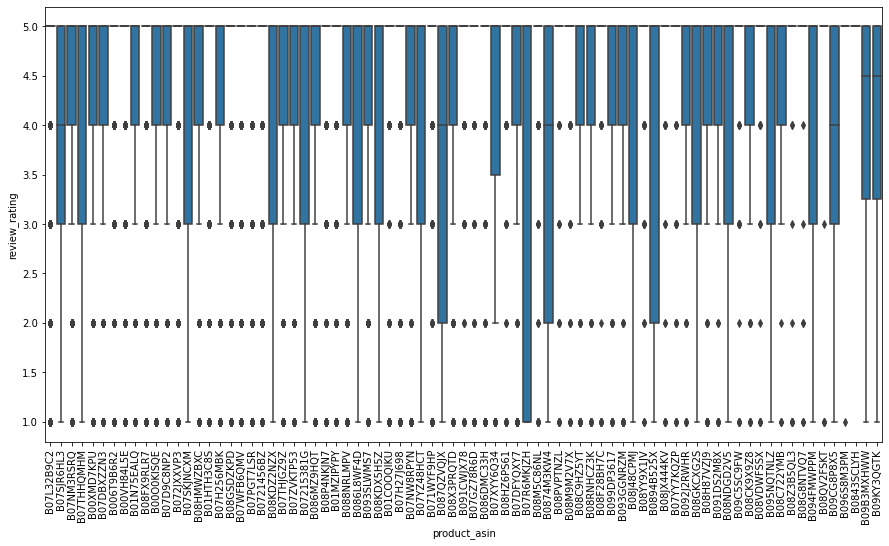

In [28]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(data=df, x="product_asin", y="review_rating",
                 order=df["product_asin"].value_counts().index, color=sns.color_palette()[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


In [29]:
from nltk.corpus import stopwords
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/pdona/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
raw_tokens = len(
    [w for t in (df["review_content"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))


Number of raw tokens: 5046847


In [31]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [32]:
# Define function to expand contractions
import re
def expand_contractions(text):
    contractions_pattern = re.compile(f"({'|'.join(CONTRACTION_MAP.keys())})", flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = CONTRACTION_MAP.get(match)\
            if CONTRACTION_MAP.get(match)\
            else CONTRACTION_MAP.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


In [33]:
def normalize_text(text: str) -> str:
    tmp_text = text.lower()
    tmp_text = expand_contractions(tmp_text)
    tmp_text = unicodedata.normalize('NFKD', tmp_text).encode(
        'ascii', 'ignore').decode('utf-8', 'ignore')
    tmp_text = re.sub(r'[^a-zA-z\s]', ' ', tmp_text)

    words = nltk.word_tokenize(tmp_text)

    stopword_list = stopwords.words('english')+['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
    stopword_list.remove('no')
    stopword_list.remove('not')
    words = [w for w in words if w not in stopword_list]

    # lemmatizer = WordNetLemmatizer()
    # lemmas = [lemmatizer.lemmatize(w, pos='v') for w in words]
    return ' '.join(words)


In [34]:
df['review_content_clean'] = df['review_content'].apply(normalize_text)


In [35]:
df['review_title_clean'] = df['review_title'].apply(normalize_text)

(-0.5, 799.5, 599.5, -0.5)

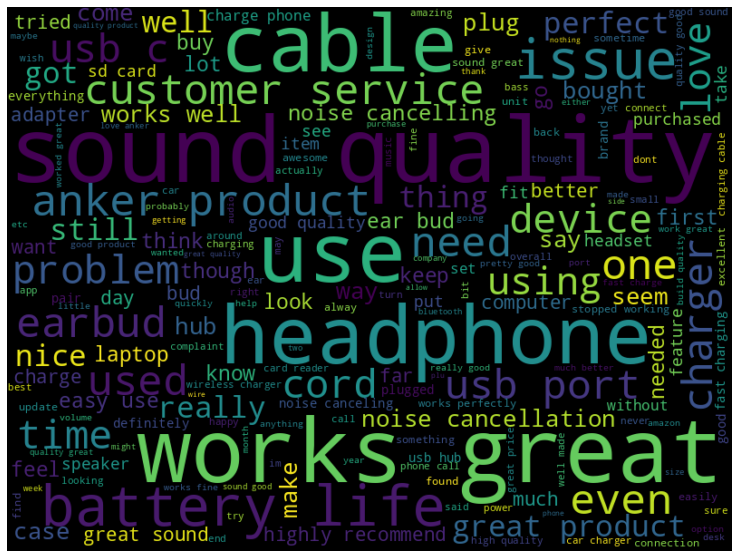

In [36]:
from wordcloud import WordCloud
positivewords = list(df.query('review_polarity > 0.05')['review_content_clean'])
positivetext = " ".join(positivewords)
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=600).generate(positivetext)

# Display the generated image:
ax = plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [37]:
df["product_asin"].sample(1)

211    B07L32B9C2
Name: product_asin, dtype: object

(-0.5, 799.5, 599.5, -0.5)

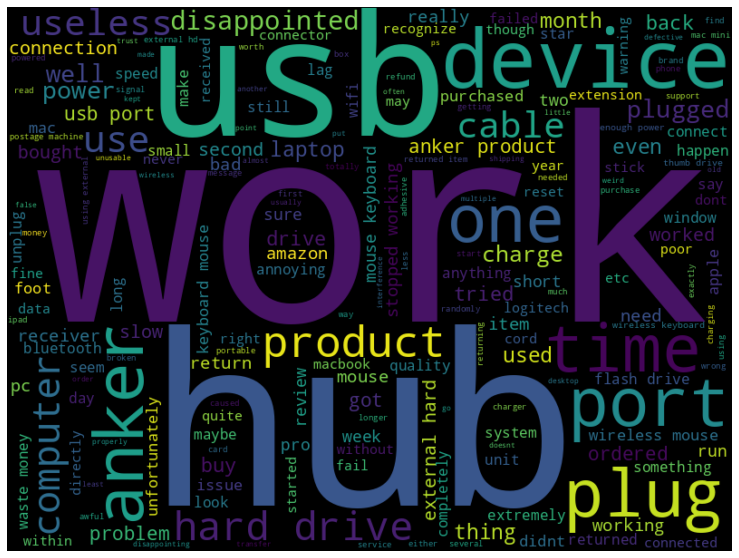

In [38]:
negativewords = list(df.query("review_polarity < -0.05 and review_rating<=2 and product_asin == 'B00O0KISQE'")
                     ['review_content_clean'])
negativetext = " ".join(negativewords)
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=600).generate(negativetext)

# Display the generated image:
ax = plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


The majority of the words are referring to what the product is? Maybe we can find an improvement if we subtract the product description and brand?

In [39]:
def subtract_product_name(content:str,name:str)->str:
    norm_name = normalize_text(name)
    name_list = nltk.word_tokenize(norm_name)
    words = nltk.word_tokenize(content)
    subtraction = [word for word in words if word not in name_list]
    return " ".join(subtraction)

In [40]:
df["review_content_clean_wotitle"] = df.apply(lambda d: subtract_product_name(
    d["review_content"], d["product_name"]), axis="columns")


In [41]:
df["review_title_clean_wotitle"] = df.apply(lambda d: subtract_product_name(
    d["review_title"], d["product_name"]), axis="columns")


In [42]:
df["review_content_clean_wotitle"].head()

0    Missing on web site is the instructions inside...
1    While using this I had a 16GB thumb and a 2TB ...
2    I travel a lot for work , so I decided to buy ...
3    I am overjoyed with this purchase . Just got a...
4    Took laptop to computer repair shop to see abo...
Name: review_content_clean_wotitle, dtype: object

(-0.5, 799.5, 599.5, -0.5)

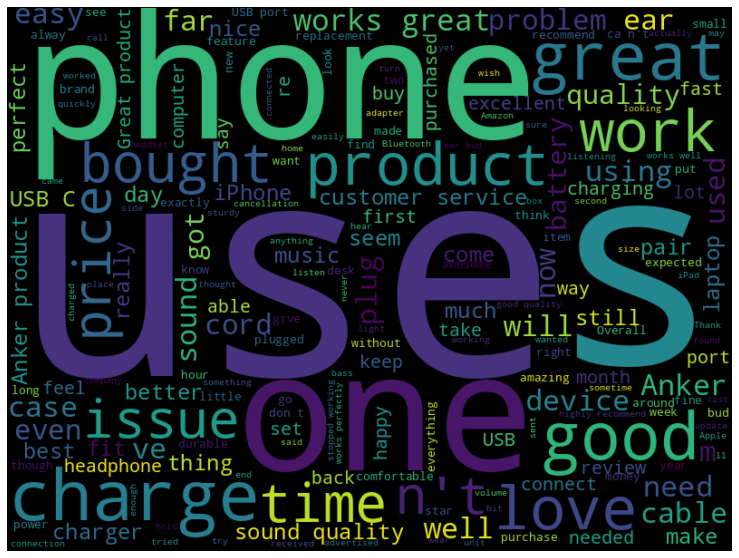

In [43]:
positivewords = list(df.query('review_polarity > 0.05')
                     ['review_content_clean_wotitle'])
positivetext = " ".join(positivewords)
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=600).generate(positivetext)

# Display the generated image:
ax = plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 799.5, 599.5, -0.5)

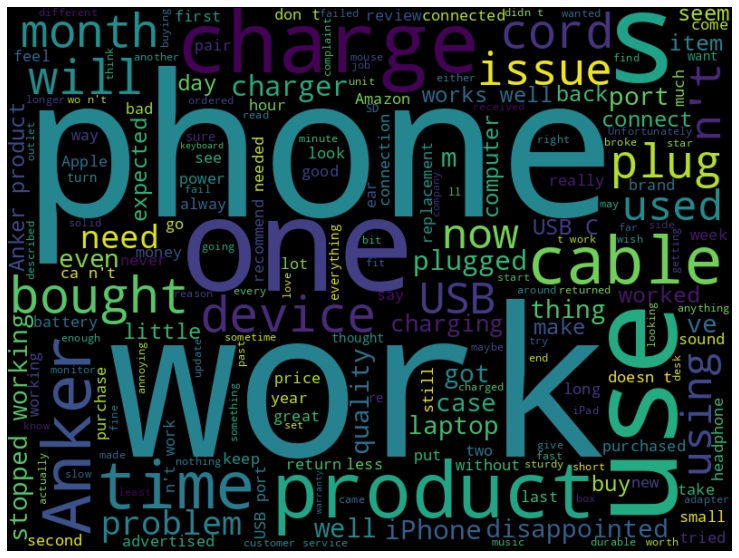

In [44]:
positivewords = list(df.query('review_polarity < 0.05')
                     ['review_content_clean_wotitle'])
positivetext = " ".join(positivewords)
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=600).generate(positivetext)

# Display the generated image:
ax = plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [45]:
df.to_csv('SentimentAnalysis/data/AnkerAmazonReviews.csv')